In [1]:
import os
print(os.getcwd())

c:\Users\dadam\OneDrive\Escritorio\EPiC-2023-Challenge\notebooks


In [2]:
import os
fold = 0
physiology_path = f"../data/raw/scenario_4/fold_{fold}/train/physiology/"
file_list = [physiology_path + f for f in os.listdir(physiology_path)]

physiology_path = f"../data/raw/scenario_4/fold_{fold}/test/physiology/"
file_list = file_list+[physiology_path + f for f in os.listdir(physiology_path)]

subs = set([os.path.split(f)[1].split("_")[1] for f in file_list])
vids = set([os.path.split(f)[1].split("_")[3] for f in file_list])

print(len(file_list), len(subs), len(vids))

240 30 8


In [3]:
import pandas as pd 
data = pd.read_csv(file_list[0])
data.shape

(131901, 9)

## Procesamiento para PPG

(10.0, 20.0)

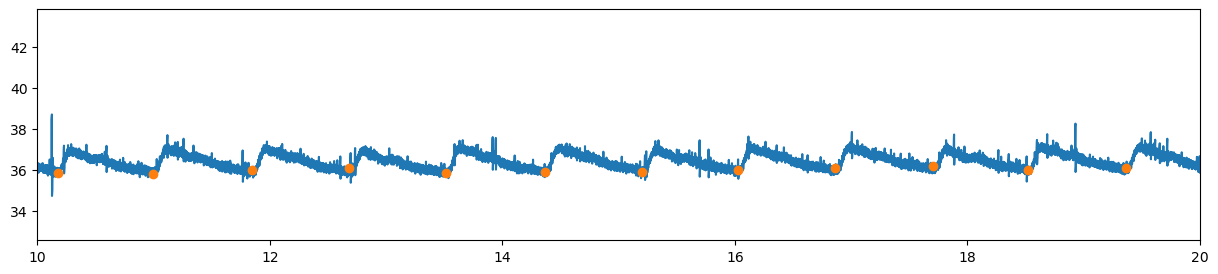

In [4]:
import biosppy
import numpy as np  
from hrvanalysis import remove_outliers
from hrvanalysis import remove_ectopic_beats
from hrvanalysis import interpolate_nan_values
from matplotlib import pyplot as plt

def process_ppg(signal, fs):
    filtered, _, _ = biosppy.tools.filter_signal(signal=signal,
                                                 ftype='butter',
                                                 band='bandpass',
                                                 order=4,
                                                 frequency=[1, 8],
                                                 sampling_rate=fs)

    peaks, _, _ = biosppy.ppg.find_onsets_kavsaoglu2016(signal=filtered,
                                                        sampling_rate=fs)
 
    rr = get_nn(peaks, fs)
    return rr, peaks

def get_nn(peaks, fs):
    """Convert beat peaks in samples to NN intervals and timestamp."""
    rr = np.diff(peaks, prepend=0) * 1000 / fs

    # This remove outliers from signal
    rr = remove_outliers(rr, low_rri=300, high_rri=2000, verbose=False)
    # This replace outliers nan values with linear interpolation
    rr = interpolate_nan_values(rr, interpolation_method="linear")

    # This remove ectopic beats from signal
    # TODO: esto puede no tener sentido en PPG, pero los metodos de features
    #  estan basados en NN y no en RR.
    rr = remove_ectopic_beats(rr, method="malik", verbose=False)
    # This replace ectopic beats nan values with linear interpolation
    rr = np.array(interpolate_nan_values(rr))

    rr[np.where(np.isnan(rr))] = 0
    
    return np.array(rr)


fs = 1000 # todo fisio es 1khz 

rr, peaks = process_ppg(data.bvp, fs)

plt.figure(figsize=(15, 3))
plt.plot(data.time/fs, data.bvp);
plt.plot(peaks/fs, data.bvp[peaks], "o");
plt.xlim([10, 20])

## Procesamiento para ECG


(10.0, 20.0)

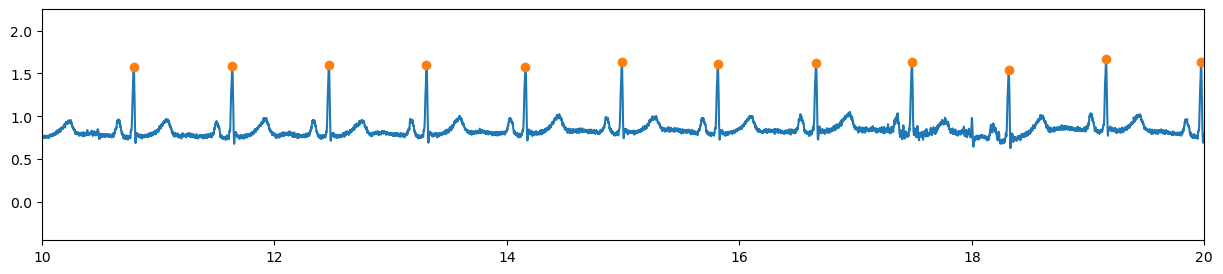

In [5]:
from biosppy.signals import ecg

def process_ecg(signal, fs):
    """Get NN interval from ecg signal."""
    _, _, rpeaks, _, _, _, _ = ecg.ecg(signal,
                                       sampling_rate=fs,
                                       show=False)
    rr = get_nn(rpeaks, fs)

    return rr, rpeaks

rr, peaks = process_ecg(data.ecg, fs)

plt.figure(figsize=(15, 3))
plt.plot(data.time/fs, data.ecg);
plt.plot(peaks/fs, data.ecg[peaks], "o");
plt.xlim([10, 20])

## Features basadas en HR (se pueden sacar del PPG o de ECG)

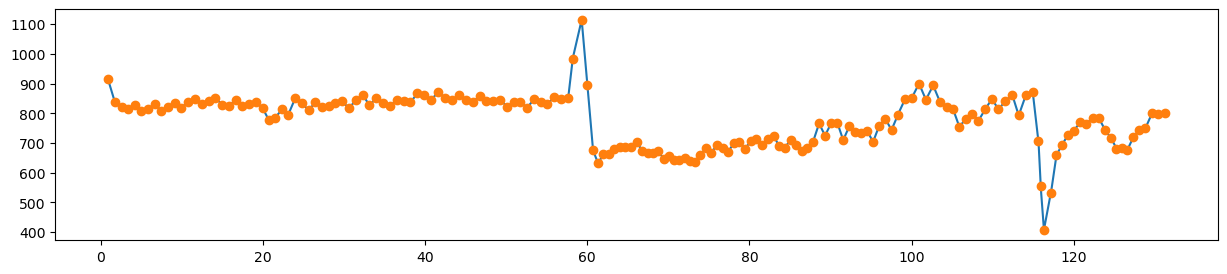

In [6]:
from scipy import interpolate

# Interpolate RR
interpf = interpolate.interp1d(peaks/fs, rr)
timestamp = np.linspace(min(peaks/fs), max(peaks/fs),
                        int((max(peaks/fs) - min(
                            peaks/fs)) * fs))
signal = interpf(timestamp)

plt.figure(figsize=(15, 3))
plt.plot(timestamp, signal);
plt.plot(peaks/fs, rr, "o");


In [7]:
signal

array([914.        , 913.90800407, 913.81600815, ..., 801.99002486,
       801.99501243, 802.        ])

In [6]:
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_frequency_domain_features
from hrvanalysis import get_geometrical_features
from hrvanalysis import get_csi_cvi_features
from hrvanalysis import get_poincare_plot_features

def hrv_features(rr):
    """Calcula diferentes feautres de HRV. Muchas requieren ventanas temporales grandes (1-5min)"""
    feats = {}

    feats.update(get_time_domain_features(rr))
    feats.update(get_geometrical_features(rr))
    feats.update(get_frequency_domain_features(rr))
    feats.update(get_csi_cvi_features(rr))
    feats.update(get_poincare_plot_features(rr))

    return feats

feat = hrv_features(rr)
len(feat)

/home/leandro/.virtualenvs/epic23/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 210, using nperseg = 210
  warnings.warn('nperseg = {0:d} is greater than input length '


31

## TODO
- Normalizar y filtrar nans
- sacar features de amplitud de PPG 
- Ver si hay diferencias importantes en feautres de HRV sino usar solo ECG
- Algunas features estan pensadas para ventanas temporales mas grandes, se podría evaluar igual en
  ventanas de 10-20 s, y si no son discriminativas se puede calcular en ventanas mas grandes y
  muestrear con las ventanas mas chicas

Estas features en un baseline sencillo (ventaneo de la señal para sacar features en el tiempo,
robusscaler y linear discriminant analysis anduvo en un caso de detección de estres)